In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob
#import metpy.calc as mpcalc
import matplotlib.animation as anim
import numpy as np
g = 9.80616 #Avg. gravity acceleration on Earth
from __future__ import print_function
from IPython.display import HTML

In [2]:
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    consolidated=True,
    storage_options={'token': 'anon'}
)

In [22]:
# Weatherbench 6-hr fields (use this for longer days)
ds = xr.open_zarr(
    'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr',
    consolidated=True,
    storage_options={'token': 'anon'}
)

In [23]:
# For western US
lat1, lat2 = 55, 15
lon1, lon2 = 200, 250

In [3]:
ds_sel = ds.sel(time=slice('2025-07-02', '2025-07-06'))

In [4]:
qu = ds_sel.specific_humidity*ds_sel.u_component_of_wind
qv = ds_sel.specific_humidity*ds_sel.v_component_of_wind

In [5]:
qu_int = 100*qu.integrate('level')/g #multiply by 100 to convert hPa to Pa (SI)
qv_int = 100*qv.integrate('level')/g

qu_int = qu_int.expand_dims({'lev': [0], 'ens': [1]})
qv_int = qv_int.expand_dims({'lev': [0], 'ens': [1]})

qu_int = qu_int.transpose('ens', 'time', 'lev', 'latitude', 'longitude')
qv_int = qv_int.transpose('ens', 'time', 'lev', 'latitude', 'longitude')

# For matlab (Guan and Waliser 2015) algorithm

In [8]:
## File parameters needed: (nlon x nlat x nlev x ntime x nens)

In [6]:
# Don't run this always
transport_ds = xr.Dataset({
    'ivtx': qu_int,
    'ivty': qv_int,
})

transport_ds.to_netcdf('/Users/rm65238/Documents/MATLAB/IVT_2025_texas_rain.nc', encoding={'time': {'calendar': 'gregorian'}})

In [13]:
new = transport_ds

In [14]:
IVT = np.sqrt(new.ivtx**2 + new.ivty**2)

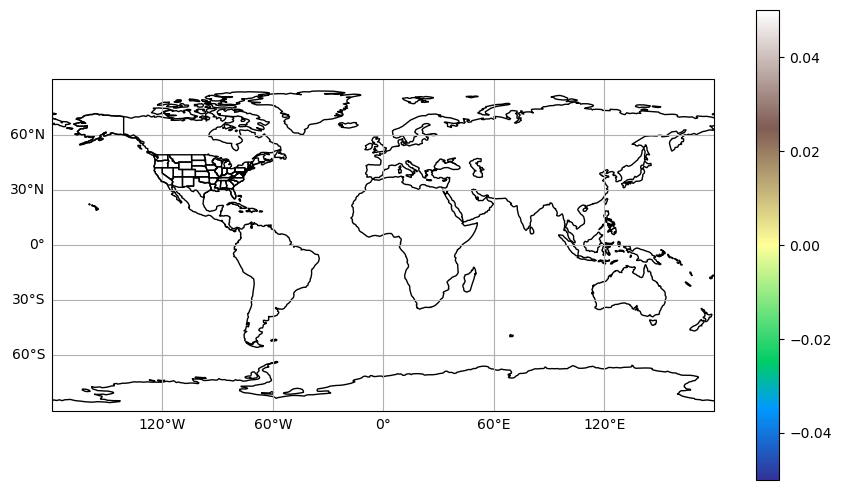

In [15]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(9,5))
gls = axs.gridlines(draw_labels=True) #color='none' makes gridlines invisible
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
cs = IVT.isel(time=2).plot(ax=axs, transform=ccrs.PlateCarree(), cmap='terrain')

axs.coastlines()
axs.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

axs.set_title(' ')
plt.tight_layout()
plt.show()

In [10]:
ds = xr.open_dataset('/Users/rm65238/Documents/MATLAB/IVT_generated.nc')

In [13]:
ds.ivty

<xarray.DataArray 'ivty' (ens: 1, time: 28, lev: 1, latitude: 721,
                          longitude: 1440)> Size: 233MB
[29070720 values with dtype=float64]
Coordinates:
  * lev        (lev) int64 8B 0
  * ens        (ens) int64 8B 1
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 224B 2022-12-26 ... 2023-01-01T18:00:00

In [18]:
ds.keys()

KeysView(<xarray.Dataset> Size: 465MB
Dimensions:    (lev: 1, ens: 1, latitude: 721, longitude: 1440, time: 28)
Coordinates:
  * lev        (lev) int64 8B 0
  * ens        (ens) int64 8B 1
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 224B 2022-12-26 ... 2023-01-01T18:00:00
Data variables:
    ivtx       (ens, time, lev, latitude, longitude) float64 233MB ...
    ivty       (ens, time, lev, latitude, longitude) float64 233MB ...)

# For python (Kennett 2021) algorithm

In [10]:
# OLD ALGORITHM
# Don't run this always
x_ds = xr.Dataset({
    'ivtx': qu_int
})

y_ds = xr.Dataset({
    'ivty': qv_int
})

In [11]:
x_ds.to_netcdf('/Users/rm65238/Documents/Kennett (2021)/input_data/e-ivt-2022-12.nc')
y_ds.to_netcdf('/Users/rm65238/Documents/Kennett (2021)/input_data/n-ivt-2022-12.nc')

In [12]:
x_ds

<xarray.Dataset> Size: 199MB
Dimensions:     (valid_time: 24, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 192B 2022-12-26 ... 2022-12-26T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B '0001'
Data variables:
    ivtx        (valid_time, latitude, longitude) float64 199MB dask.array<chunksize=(1, 361, 720), meta=np.ndarray>

# Check land-sea mask file

In [43]:
mask = xr.open_dataset('/Users/rm65238/Documents/MATLAB/ERA5 land sea mask.nc')

In [50]:
mask_new = mask.rename({
    'lsm': 'islnd','valid_time': 'time'})

In [52]:
mask_new.to_netcdf('/Users/rm65238/Documents/MATLAB/era5_islnd.nc', encoding={'time': {'calendar': 'gregorian'}})

In [53]:
mask_new.keys()

KeysView(<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 8B 2017-12-01
Data variables:
    islnd      (time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-24T18:07 GRIB to CDM+CF via cfgrib-0.9.1...)

In [21]:
ds = xr.open_dataset('/Users/rm65238/Documents/MATLAB/ivt_example.nc')

In [22]:
IVT = np.sqrt(ds.ivtx**2 + ds.ivty**2)

In [23]:
IVT

<xarray.DataArray (ens: 1, time: 12, lev: 1, lat: 121, lon: 240)> Size: 1MB
array([[[[[17.518438 , 17.518843 , 17.519266 , ..., 17.518894 ,
           17.5199   , 17.518963 ],
          [17.613207 , 17.659445 , 17.706413 , ..., 17.455952 ,
           17.507282 , 17.561075 ],
          [17.787409 , 17.80615  , 17.82917  , ..., 17.726555 ,
           17.745375 , 17.767094 ],
          ...,
          [78.202866 , 80.41372  , 82.72667  , ..., 68.78798  ,
           71.79671  , 74.938324 ],
          [91.16061  , 91.97414  , 92.78102  , ..., 87.72613  ,
           88.87733  , 90.02509  ],
          [92.41195  , 92.41184  , 92.41248  , ..., 92.41195  ,
           92.41076  , 92.41157  ]]],


        [[[17.077162 , 17.076786 , 17.077305 , ..., 17.077442 ,
           17.07692  , 17.076824 ],
          [20.84099  , 20.918234 , 20.99639  , ..., 20.62921  ,
           20.701048 , 20.770514 ],
          [20.712069 , 20.975956 , 21.244152 , ..., 20.158205 ,
...
           11.445162 , 11.05551  ],
          [ 3.3084857,  3.5821385,  3.8997016, ...,  2.8291569,
            2.9283206,  3.089296 ],
          [13.490894 , 13.491879 , 13.490875 , ..., 13.49068  ,
           13.49107  , 13.4910555]]],


        [[[12.188216 , 12.188268 , 12.187713 , ..., 12.188362 ,
           12.188243 , 12.188287 ],
          [13.807685 , 13.825825 , 13.845387 , ..., 13.72261  ,
           13.750656 , 13.777578 ],
          [15.667855 , 15.702228 , 15.741249 , ..., 15.611657 ,
           15.62347  , 15.640781 ],
          ...,
          [14.129684 , 13.61364  , 13.048272 , ..., 15.398987 ,
           15.025671 , 14.600857 ],
          [ 7.185353 ,  7.215677 ,  7.269311 , ...,  7.232669 ,
            7.1961966,  7.1792474],
          [13.673042 , 13.672889 , 13.673046 , ..., 13.673073 ,
           13.673017 , 13.67287  ]]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
  * lat      (lat) float64 968B -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5 90.0
  * lev      (lev) float64 8B 1e+03
  * time     (time) datetime64[ns] 96B 1996-12-30 ... 1997-01-01T18:00:00
  * ens      (ens) float64 8B 1.0